In [1]:
import tarfile
import os
import nibabel as nib
import numpy as np
import os
import random

from scipy.ndimage import gaussian_filter, rotate
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.optim import Adam
from torchinfo import summary

import matplotlib.pyplot as plt


In [2]:
# Path to the TAR file
tar_path = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'
extract_path = '/kaggle/working/BraTS2021_Training_Data'

# Extract the TAR file
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)


In [3]:
def load_nifti(file_path):
    """
    Load a NIfTI file and convert it to a NumPy array.
    """
    img = nib.load(file_path)
    return img.get_fdata()

def preprocess_modality(modality_path):
    """
    Normalize the modality data.
    """
    data = load_nifti(modality_path)
    # Normalize (z-score)
    mean, std = data.mean(), data.std()
    return (data - mean) / std


In [4]:

# Define augmentations
def apply_rician_noise(image):
    """
    Apply Rician noise to the image.
    """
    noise = np.random.normal(0, 0.1, image.shape)
    return np.sqrt((image + noise) ** 2 + noise ** 2)


def apply_low_resolution(image, scale_factor=0.5):
    """
    Simulate low resolution by downsampling and upsampling.
    """
    low_res = gaussian_filter(image, sigma=2)
    return low_res


def apply_rotation(image, angle=15):
    """
    Rotate the image by a random angle.
    """
    rotated = np.stack([rotate(slice, angle=angle, reshape=False) for slice in image])
    return rotated


def apply_augmentation(image, augment_type):
    """
    Apply the selected augmentation type to the image.
    """
    if augment_type == "rician":
        return apply_rician_noise(image)
    elif augment_type == "low_res":
        return apply_low_resolution(image)
    elif augment_type == "rotation":
        angle = random.uniform(-15, 15)  # Random angle between -15 and 15 degrees
        return apply_rotation(image, angle)
    elif augment_type == "rician_rotation":
        return apply_rotation(apply_rician_noise(image))
    elif augment_type == "low_res_rotation":
        return apply_rotation(apply_low_resolution(image))
    elif augment_type == "all":
        return apply_rotation(apply_low_resolution(apply_rician_noise(image)))
    else:  # "none"
        return image


# Dataset Class with Augmentation
class BraTSDataset(Dataset):
    def __init__(self, root_dir, num_classes, transform=None):
        self.root_dir = root_dir
        self.num_classes = num_classes
        self.transform = transform
        self.patients = [
            folder for folder in sorted(os.listdir(root_dir))
            if not folder.startswith('.')
        ]

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_dir = os.path.join(self.root_dir, self.patients[idx])
    
        # Load modalities
        t1 = preprocess_modality(os.path.join(patient_dir, f"{self.patients[idx]}_t1.nii.gz"))
        t1ce = preprocess_modality(os.path.join(patient_dir, f"{self.patients[idx]}_t1ce.nii.gz"))
        t2 = preprocess_modality(os.path.join(patient_dir, f"{self.patients[idx]}_t2.nii.gz"))
        flair = preprocess_modality(os.path.join(patient_dir, f"{self.patients[idx]}_flair.nii.gz"))
    
        # Load segmentation and ensure valid range
        seg = load_nifti(os.path.join(patient_dir, f"{self.patients[idx]}_seg.nii.gz"))
        seg = torch.tensor(seg, dtype=torch.long)
        seg = torch.clamp(seg, min=0, max=self.num_classes - 1)  # Ensure valid range
    
        # One-hot encode
        seg_one_hot = F.one_hot(seg, num_classes=self.num_classes).permute(3, 0, 1, 2).float()
    
        # Combine modalities into a tensor
        image = np.stack([t1, t1ce, t2, flair], axis=0)
        image = torch.tensor(image, dtype=torch.float32)
    
        # Randomly select an augmentation type
        augment_type = random.choices(
            ["none", "rician", "low_res", "rotation", "rician_rotation", "low_res_rotation", "all"],
            weights=[0.75, 0.05, 0.05, 0.05, 0.025, 0.025, 0.05],
            k=1
        )[0]
    
        # Apply augmentation
        image = apply_augmentation(image.numpy(), augment_type)
        image = torch.tensor(image, dtype=torch.float32)
    
        return image, seg_one_hot




In [5]:

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv3d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.projection(x)  # (B, embed_dim, D, H, W)
        self.d, self.h, self.w = x.shape[2:]  # Store dimensions for later use
        B, C, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, feedforward_dim):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.layernorm1(x + attn_output)
        
        # Feedforward
        ff_output = self.feedforward(x)
        x = self.layernorm2(x + ff_output)
        return x

class TransformerSegmentation(nn.Module):
    def __init__(
        self,
        input_channels,
        patch_size,
        embed_dim,
        depth,
        heads,
        mlp_dim,
        dropout_rate=0.1,
        attn_dropout_rate=0.1,
        num_classes=4,
    ):
        super().__init__()
        self.embedding = PatchEmbedding(
            in_channels=input_channels, patch_size=patch_size, embed_dim=embed_dim
        )
        self.transformer = nn.Sequential(
            *[
                TransformerBlock(embed_dim, heads, mlp_dim)
                for _ in range(depth)
            ]
        )
        self.output_projection = nn.Conv3d(embed_dim, num_classes, kernel_size=1)

    def forward(self, x):
        # Embed patches
        x = self.embedding(x)

        # Process with transformer
        x = self.transformer(x)

        # Reshape back to spatial dimensions
        B, num_patches, embed_dim = x.shape
        x = x.transpose(1, 2).reshape(B, embed_dim, self.embedding.d, self.embedding.h, self.embedding.w)
        x = self.output_projection(x)  # Final segmentation output
        return x



In [6]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1.0

        # Apply softmax to logits to get probabilities
        probs = torch.softmax(logits, dim=1)

        # Compute Dice loss
        intersection = (probs * targets).sum(dim=(2, 3, 4))
        union = probs.sum(dim=(2, 3, 4)) + targets.sum(dim=(2, 3, 4))
        dice = (2.0 * intersection + smooth) / (union + smooth)

        return 1 - dice.mean()

In [7]:
# Training Function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode="trilinear", align_corners=False)
        
        # Compute loss
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [8]:
def evaluate(model, loader, criterion, device, max_samples=10):
    model.eval()
    val_loss = 0.0
    dice_scores = []
    stored_outputs = []
    stored_masks = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            images, masks = images.to(device), masks.to(device)

            # Get model predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Resize outputs to match mask dimensions if needed
            if outputs.shape != masks.shape:
                outputs = F.interpolate(outputs, size=masks.shape[2:], mode="trilinear", align_corners=False)

            # Compute loss
            val_loss += criterion(outputs, masks).item()

            # Compute Dice score
            preds = (outputs > 0.5).float()
            dice_score = (2 * (preds * masks).sum()) / ((preds + masks).sum() + 1e-8)
            dice_scores.append(dice_score.item())

            # Store a limited number of predictions and masks for analysis
            if len(stored_outputs) < max_samples:
                stored_outputs.append(outputs.cpu())
                stored_masks.append(masks.cpu())

    avg_loss = val_loss / len(loader)
    avg_dice_score = sum(dice_scores) / len(dice_scores)

    return avg_loss, avg_dice_score, stored_outputs, stored_masks, images


In [9]:
num_classes = 4  

# Initialize the dataset
dataset = BraTSDataset(root_dir=extract_path, num_classes=num_classes)
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_idx, test_idx = train_test_split(range(len(train_idx)), test_size = 0.15, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)


# Debug the DataLoader
for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    print("Mask unique values:", torch.unique(masks))
    break  # Debug only one batch

for images, masks in test_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    print("Mask unique values:", torch.unique(masks))
    break  # Debug only one batch

Image batch shape: torch.Size([1, 4, 240, 240, 155])
Mask batch shape: torch.Size([1, 4, 240, 240, 155])
Mask unique values: tensor([0., 1.])
Image batch shape: torch.Size([1, 4, 240, 240, 155])
Mask batch shape: torch.Size([1, 4, 240, 240, 155])
Mask unique values: tensor([0., 1.])


In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerSegmentation(
    input_channels=4, patch_size=4, embed_dim=128, depth=6, heads=8, mlp_dim=512, num_classes=4
).to(device)

# Free GPU cache
torch.cuda.empty_cache()

# Train with reduced batch size
batch_size = 1


# Initialize optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = DiceLoss()

# Training loop
num_epochs = 13
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, dice_score, outputs, masks, images = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Dice Score: {dice_score:.4f}")

In [ ]:
# Define a smaller subset size for debugging
subset_size = 100  # Choose the number of samples to include in your debug dataset
indices = random.sample(range(len(dataset)), subset_size)
debug_dataset = Subset(dataset, indices)

# Create DataLoaders for the debug dataset
debug_train_loader = DataLoader(debug_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
debug_test_loader = DataLoader(debug_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Free GPU cache before training
torch.cuda.empty_cache()

num_epochs = 3  # Use fewer epochs for debugging
for epoch in range(num_epochs):
    train_loss = train_epoch(model, debug_train_loader, optimizer, criterion, device)
    val_loss, dice_score, outputs, masks, images = evaluate(model, debug_test_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Dice Score: {dice_score:.4f}")

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/transbts_model1.pth')
print("Model saved!")

In [10]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = TransformerSegmentation(
    input_channels=4, patch_size=4, embed_dim=128, depth=6, heads=8, mlp_dim=512, num_classes=4
).to(device)

# Free GPU cache
torch.cuda.empty_cache()

model1.load_state_dict(torch.load('/kaggle/input/transbts1/pytorch/1/1/transbts_model1.pth'))
model1.eval()


/tmp/ipykernel_23/1223777967.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('/kaggle/input/transbts1/pytorch/1/1/transbts_model1.pth'

TransformerSegmentation(
  (embedding): PatchEmbedding(
    (projection): Conv3d(4, 128, kernel_size=(4, 4, 4), stride=(4, 4, 4))
  )
  (transformer): Sequential(
    (0): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_feat

In [ ]:
# Run evaluation

optimizer = Adam(model1.parameters(), lr=1e-4)
criterion = DiceLoss()

# Run evaluation
val_loss1, dice_score1, outputs1, masks1, images1 = evaluate(model1, test_loader, criterion, device)


In [15]:
print(f"Validation Loss: {val_loss1:.4f}, Dice Score: {dice_score1:.4f}")

Validation Loss: 0.8521, Dice Score: 0.6670


In [16]:
# Run evaluation

optimizer = Adam(model2.parameters(), lr=1e-4)
criterion = DiceLoss()

# Run evaluation
val_loss2, dice_score2, outputs2, masks2, images2 = evaluate(model2, test_loader, criterion, device)

In [17]:
print(f"Validation Loss: {val_loss2:.4f}, Dice Score: {dice_score2:.4f}")

Validation Loss: 0.8567, Dice Score: 0.6659


In [18]:
# Run evaluation

optimizer = Adam(model3.parameters(), lr=1e-4)
criterion = DiceLoss()

# Run evaluation
val_loss3, dice_score3, outputs3, masks3, images3 = evaluate(model3, test_loader, criterion, device)

In [19]:
print(f"Validation Loss: {val_loss3:.4f}, Dice Score: {dice_score3:.4f}")

Validation Loss: 0.8567, Dice Score: 0.6659


In [20]:
print(f"Number of samples: {len(outputs1)}")
print(f"Output shape for the first sample: {outputs1[0].shape}")

print(f"Number of samples: {len(outputs2)}")
print(f"Output shape for the first sample: {outputs2[0].shape}")

print(f"Number of samples: {len(outputs3)}")
print(f"Output shape for the first sample: {outputs3[0].shape}")

Number of samples: 10
Output shape for the first sample: torch.Size([1, 4, 240, 240, 155])
Number of samples: 10
Output shape for the first sample: torch.Size([1, 4, 240, 240, 155])
Number of samples: 10
Output shape for the first sample: torch.Size([1, 4, 240, 240, 155])


In [51]:
print(f"Number of samples: {len(outputs3)}")
print(f"Output shape for the first sample: {outputs3[2].shape}")

print("Mask batch shape:", len(masks3))
print("Image batch shape:", images3.shape)

Number of samples: 10
Output shape for the first sample: torch.Size([1, 4, 240, 240, 155])
Mask batch shape: 10
Image batch shape: torch.Size([1, 4, 240, 240, 155])


In [46]:
outputs_1 = outputs3[4]  # First sample's output
masks_1 = masks3[4]      # Corresponding ground truth
images_1 = images3[0]

# Convert logits to segmentation map (argmax for multi-class, threshold for binary)
predicted_segmentation = torch.argmax(outputs_1, dim=1).squeeze(0).cpu().numpy()
true_segmentation = torch.argmax(masks_1, dim=1).squeeze(0).cpu().numpy()
images_1 = images_1.cpu().numpy()

print("Predicted Segmentation Shape:", predicted_segmentation.shape)
print("True Segmentation Shape:", true_segmentation.shape)
print("Image Shape:", images_1.shape)

Predicted Segmentation Shape: (240, 240, 155)
True Segmentation Shape: (240, 240, 155)
Image Shape: (4, 240, 240, 155)


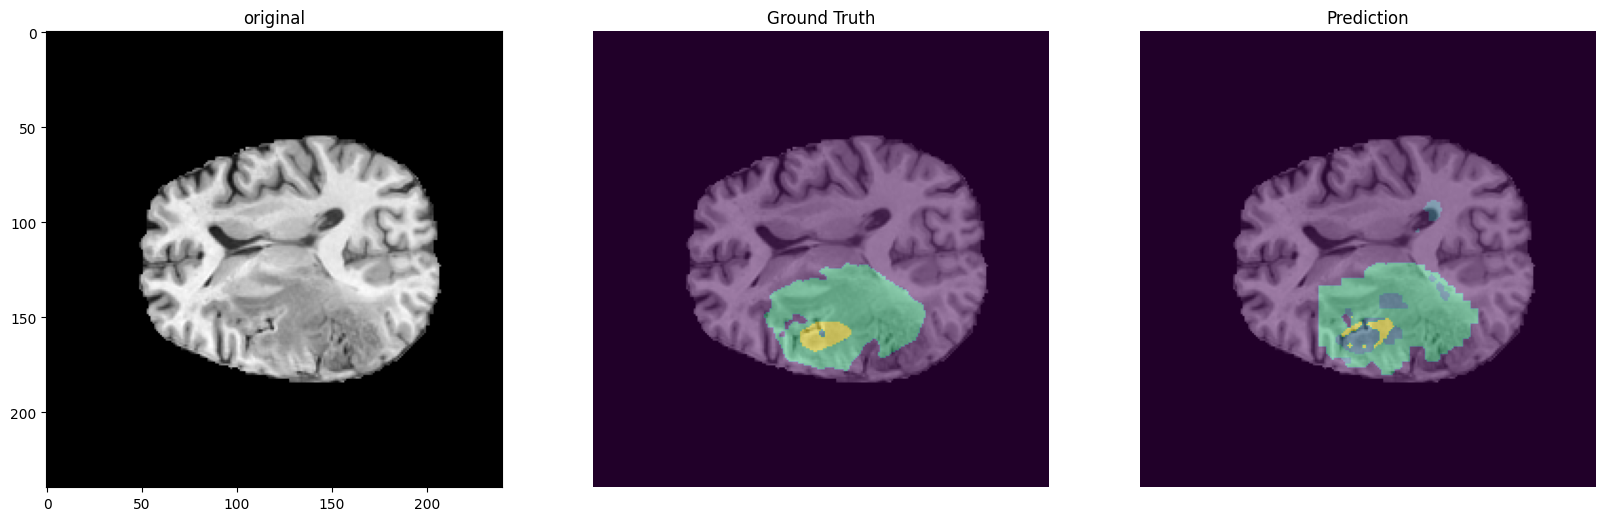

In [48]:


# Visualize a slice (for example: axial plane at index 90)
slice_idx = 80

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")

# Ground Truth
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")
plt.imshow(true_segmentation[:, :, slice_idx], cmap="viridis", alpha = 0.5, vmin = 0, vmax = 3)
plt.axis("off")

# Prediction
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")
plt.imshow(predicted_segmentation[:, :, slice_idx], cmap="viridis" , alpha = 0.5, vmin = 0, vmax = 3)
plt.axis("off")

plt.show()


In [103]:
def evaluate_noisy(model, loader, criterion, device, max_samples=15):
    model.eval()
    val_loss = 0.0
    dice_scores = []
    precision_scores = []
    recall_scores = []
    iou_scores = []
    specificity_scores = []
    accuracy_scores = []
    stored_outputs = []
    stored_masks = []
    stored_images = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            images, masks = images.to(device), masks.to(device)

            # Get model predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            # Resize outputs to match mask dimensions if needed
            if outputs.shape != masks.shape:
                outputs = F.interpolate(outputs, size=masks.shape[2:], mode="trilinear", align_corners=False)

            # Compute loss
            val_loss += criterion(outputs, masks).item()

            # Threshold outputs to get binary predictions
            preds = (outputs > 0.5).float()

            # Compute metrics per batch
            batch_size = images.size(0)
            for j in range(batch_size):
                pred = preds[j]
                mask = masks[j]

                # Flatten predictions and masks
                pred_flat = pred.view(-1)
                mask_flat = mask.view(-1)

                # True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
                TP = (pred_flat * mask_flat).sum()
                FP = (pred_flat * (1 - mask_flat)).sum()
                FN = ((1 - pred_flat) * mask_flat).sum()
                TN = ((1 - pred_flat) * (1 - mask_flat)).sum()

                # Compute metrics
                precision = TP / (TP + FP + 1e-8)
                recall = TP / (TP + FN + 1e-8)
                f1 = 2 * precision * recall / (precision + recall + 1e-8)
                iou = TP / (TP + FP + FN + 1e-8)
                dice = (2 * TP + 1e-8) / (TP + FP + FN + TP + 1e-8)
                specificity = TN / (TN + FP + 1e-8)
                accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)

                # Append metrics
                precision_scores.append(precision.item())
                recall_scores.append(recall.item())
                iou_scores.append(iou.item())
                dice_scores.append(dice.item())
                specificity_scores.append(specificity.item())
                accuracy_scores.append(accuracy.item())

            # Store a limited number of predictions and masks for analysis
            if len(stored_outputs) < max_samples:
                stored_outputs.append(outputs.cpu())
                stored_masks.append(masks.cpu())
                stored_images.append(images.cpu())

    avg_loss = val_loss / len(loader)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_iou_score = sum(iou_scores) / len(iou_scores)
    avg_dice_score = sum(dice_scores) / len(dice_scores)
    avg_specificity = sum(specificity_scores) / len(specificity_scores)
    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_f1_score = 2 * avg_precision * avg_recall / (avg_precision + avg_recall + 1e-8)

    # Print detailed metrics
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Average Dice Score: {avg_dice_score:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")
    print(f"Average IoU Score: {avg_iou_score:.4f}")
    print(f"Average Specificity: {avg_specificity:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_dice_score, avg_precision, avg_recall, avg_f1_score, avg_iou_score, avg_specificity, avg_accuracy, stored_outputs, stored_masks, stored_images

In [104]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = TransformerSegmentation(
    input_channels=4, patch_size=4, embed_dim=128, depth=6, heads=8, mlp_dim=512, num_classes=4
).to(device)

# Free GPU cache
torch.cuda.empty_cache()

model1.load_state_dict(torch.load('/kaggle/input/transbts1/pytorch/1/1/transbts_model1.pth'))

# Set up device
model1.to(device)

# Run evaluation
avg_loss, avg_dice_score, avg_precision, avg_recall, avg_f1_score, avg_iou_score, avg_specificity, avg_accuracy, outputs, masks, images = evaluate_noisy(model1, test_loader, criterion, device)


/tmp/ipykernel_23/912665109.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('/kaggle/input/transbts1/pytorch/1/1/transbts_model1.pth')

Validation Loss: 0.8520
Average Dice Score: 0.6669
Average Precision: 0.5007
Average Recall: 0.9984
Average F1 Score: 0.6669
Average IoU Score: 0.5003
Average Specificity: 0.6682
Average Accuracy: 0.7507


In [106]:

summary(model1, (1, 4, 240, 240, 155))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerSegmentation                  [1, 4, 60, 60, 38]        --
├─PatchEmbedding: 1-1                    [1, 136800, 128]          --
│    └─Conv3d: 2-1                       [1, 128, 60, 60, 38]      32,896
├─Sequential: 1-2                        [1, 136800, 128]          --
│    └─TransformerBlock: 2-2             [1, 136800, 128]          --
│    │    └─MultiheadAttention: 3-1      [1, 136800, 128]          66,048
│    │    └─LayerNorm: 3-2               [1, 136800, 128]          256
│    │    └─Sequential: 3-3              [1, 136800, 128]          131,712
│    │    └─LayerNorm: 3-4               [1, 136800, 128]          256
│    └─TransformerBlock: 2-3             [1, 136800, 128]          --
│    │    └─MultiheadAttention: 3-5      [1, 136800, 128]          66,048
│    │    └─LayerNorm: 3-6               [1, 136800, 128]          256
│    │    └─Sequential: 3-7              [1, 136800, 128]        

In [107]:
print(f"Number of samples: {len(outputs)}")
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

print(f"Output shape for the first sample: {outputs[2].shape}")

print("Mask batch shape:", masks[2].shape)
print("Image batch shape:", images[2].shape)

Number of samples: 15
Number of images: 15
Number of masks: 15
Output shape for the first sample: torch.Size([1, 4, 240, 240, 155])
Mask batch shape: torch.Size([1, 4, 240, 240, 155])
Image batch shape: torch.Size([1, 4, 240, 240, 155])


In [ ]:
pip install visualtorch

In [123]:
outputs_1 = outputs[14]  # Sample number 3
masks_1 = masks[14]      # Corresponding ground truth
images_1 = images[14]    # Corr Image

# Convert logits to segmentation map (argmax for multi-class, threshold for binary)
predicted_segmentation = torch.argmax(outputs_1, dim=1).squeeze(0).cpu().numpy()
true_segmentation = torch.argmax(masks_1, dim=1).squeeze(0).cpu().numpy()


print("Predicted Segmentation Shape:", predicted_segmentation.shape)
print("True Segmentation Shape:", true_segmentation.shape)


Predicted Segmentation Shape: (240, 240, 155)
True Segmentation Shape: (240, 240, 155)


In [124]:
images_1 = images_1.squeeze(0).cpu().numpy()

print("Image Shape:", images_1.shape)

Image Shape: (4, 240, 240, 155)


In [125]:
print("Predicted Segmentation Shape:", predicted_segmentation.shape)
print("True Segmentation Shape:", true_segmentation.shape)
print("Image Shape:", images_1.shape)

Predicted Segmentation Shape: (240, 240, 155)
True Segmentation Shape: (240, 240, 155)
Image Shape: (4, 240, 240, 155)


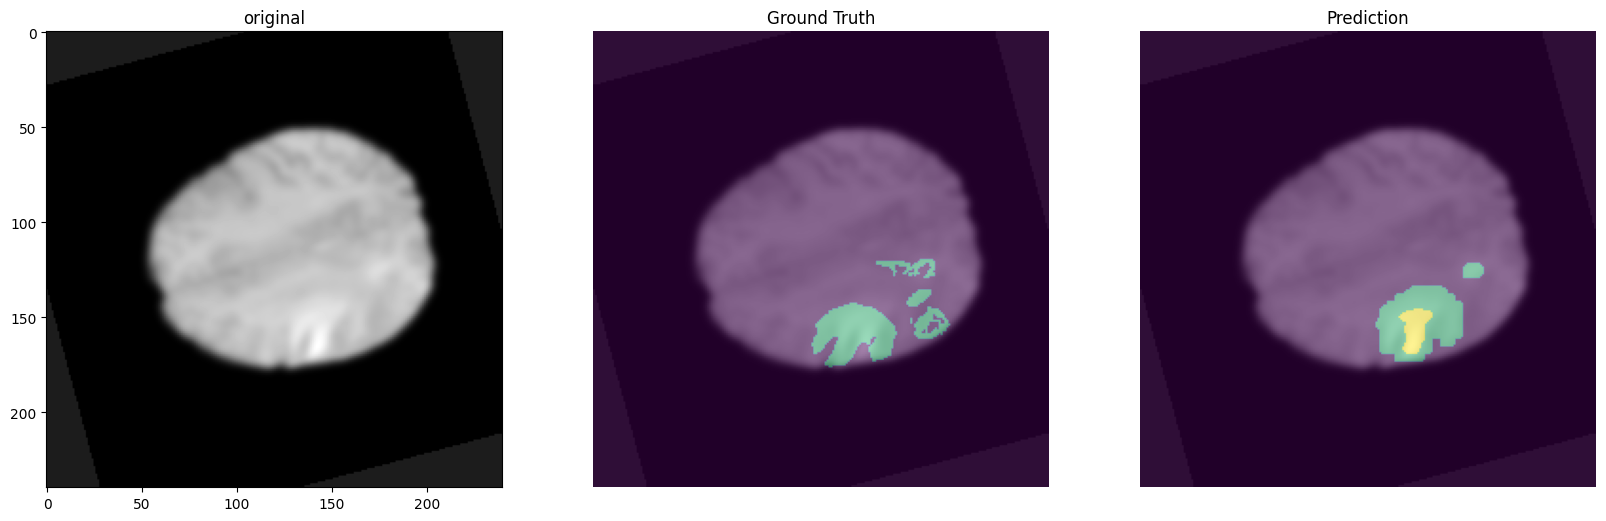

In [126]:
# Visualize a slice (for example: axial plane at index 90)
slice_idx = 100

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")

# Ground Truth
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")
plt.imshow(true_segmentation[:, :, slice_idx], cmap="viridis", alpha = 0.5, vmin = 0, vmax = 3)
plt.axis("off")

# Prediction
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(images_1[0][:,:,slice_idx], cmap="gray")
plt.imshow(predicted_segmentation[:, :, slice_idx], cmap="viridis" , alpha = 0.5, vmin = 0, vmax = 3)
plt.axis("off")

plt.show()